## Modules and repo

In [1]:
!pip install -q diffusers transformers accelerate

In [2]:
import sys
import torch
import torch.nn.functional as F
from diffusers import UNet2DConditionModel, AutoencoderKL, DDPMScheduler, StableDiffusionPipeline
from transformers import CLIPTextModel, CLIPTokenizer
from typing import Tuple
from torch.utils.data import DataLoader
import os
import json
from datetime import datetime

!rm -rf semantic-correspondence

!git clone https://github.com/MarcotteS/semantic-correspondence.git
import sys
sys.path.append('/content/semantic-correspondence/src')

Flax classes are deprecated and will be removed in Diffusers v1.0.0. We recommend migrating to PyTorch classes or pinning your version of Diffusers.
Flax classes are deprecated and will be removed in Diffusers v1.0.0. We recommend migrating to PyTorch classes or pinning your version of Diffusers.


Cloning into 'semantic-correspondence'...
remote: Enumerating objects: 227, done.
remote: Counting objects: 100% (12/12), done.
remote: Compressing objects: 100% (10/10), done.
remote: Total 227 (delta 4), reused 6 (delta 2), pack-reused 215 (from 1)
Receiving objects: 100% (227/227), 3.17 MiB | 29.55 MiB/s, done.
Resolving deltas: 100% (127/127), done.


In [3]:
from analyzer import ResultsAnalyzer
from evaluation import CorrespondenceEvaluator,evaluate_model
from correspondence import CorrespondenceMatcher
from dataset import SPairDataset,denorm,draw_image_with_keypoints,visualize_sample,collate_fn_correspondence

## Loading weights

In [4]:
!hf auth login

WEIGHTS_PATH = "/content/sd-1-5-weights"

if os.path.exists(WEIGHTS_PATH):
    print("Weights already downloaded, skipping...")
else:
    pipe = StableDiffusionPipeline.from_pretrained(
        "runwayml/stable-diffusion-v1-5",
        torch_dtype=torch.float16
    )

    pipe.save_pretrained(WEIGHTS_PATH)
    print(f"Weights saved to {WEIGHTS_PATH}")


    _|    _|  _|    _|    _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|_|_|_|    _|_|      _|_|_|  _|_|_|_|
    _|    _|  _|    _|  _|        _|          _|    _|_|    _|  _|            _|        _|    _|  _|        _|
    _|_|_|_|  _|    _|  _|  _|_|  _|  _|_|    _|    _|  _|  _|  _|  _|_|      _|_|_|    _|_|_|_|  _|        _|_|_|
    _|    _|  _|    _|  _|    _|  _|    _|    _|    _|    _|_|  _|    _|      _|        _|    _|  _|        _|
    _|    _|    _|_|      _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|        _|    _|    _|_|_|  _|_|_|_|

    To log in, `huggingface_hub` requires a token generated from https://huggingface.co/settings/tokens .
Enter your token (input will not be visible): 
Add token as git credential? (Y/n) n
Token is valid (permission: read).
The token `colab` has been saved to /root/.cache/huggingface/stored_tokens
Your token has been saved to /root/.cache/huggingface/token
Login successful.
The current active token is: `colab`


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model_index.json:   0%|          | 0.00/541 [00:00<?, ?B/s]

Fetching 15 files:   0%|          | 0/15 [00:00<?, ?it/s]

config.json:   0%|          | 0.00/617 [00:00<?, ?B/s]

scheduler_config.json:   0%|          | 0.00/308 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

config.json: 0.00B [00:00, ?B/s]

preprocessor_config.json:   0%|          | 0.00/342 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/806 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

config.json:   0%|          | 0.00/743 [00:00<?, ?B/s]

safety_checker/model.safetensors:   0%|          | 0.00/1.22G [00:00<?, ?B/s]

text_encoder/model.safetensors:   0%|          | 0.00/492M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/547 [00:00<?, ?B/s]

vae/diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

unet/diffusion_pytorch_model.safetensors:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

`torch_dtype` is deprecated! Use `dtype` instead!


Weights saved to /content/sd-1-5-weights


## Stable Diffusion Extractor

In [5]:
class StableDiffusionExtractor:
    """
    Stable Diffusion 1.5 Feature Extractor for Semantic Correspondence.
    Extracts features from U-Net intermediate layers during denoising process.
    Based on DIFT: "Emergent Correspondence from Image Diffusion" (NeurIPS 2023)
    """

    def __init__(
        self,
        weights: str,
        model_name: str = "sd-1-5",
        timestep: int = 261,
        layer_name: str = "up_blocks.0",
        patch_size: int = 16,
    ):
        """
        Initialize SD 1.5 feature extractor.

        Args:
            weights: Path to local SD weights directory
            model_name: Label for this model (for results tracking)
            timestep: Denoising timestep to extract features (DIFT uses 261)
            layer_name: Which U-Net layer to extract from
                       Options: "up_blocks.0", "up_blocks.1", "up_blocks.2",
                               "down_blocks.0", "down_blocks.1", "down_blocks.2"
            patch_size: Virtual patch size (compatibility with ViT-style extractors)
        """
        print(f"Initializing SD extractor from: {weights}")

        if not os.path.exists(weights):
            raise ValueError(f"Weights directory not found: {weights}")

        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.dtype = torch.float16 if torch.cuda.is_available() else torch.float32

        # Load U-Net
        print("  Loading UNet...")
        self.unet = UNet2DConditionModel.from_pretrained(
            weights,
            subfolder="unet",
            torch_dtype=self.dtype,
            local_files_only=True
        ).to(self.device)

        # Load VAE (for encoding images to latent space)
        print("  Loading VAE...")
        self.vae = AutoencoderKL.from_pretrained(
            weights,
            subfolder="vae",
            torch_dtype=self.dtype,
            local_files_only=True
        ).to(self.device)

        # Load text encoder (even though we use empty prompts)
        print("  Loading text encoder...")
        self.text_encoder = CLIPTextModel.from_pretrained(
            weights,
            subfolder="text_encoder",
            torch_dtype=self.dtype,
            local_files_only=True
        ).to(self.device)

        # Load tokenizer
        print("  Loading tokenizer...")
        self.tokenizer = CLIPTokenizer.from_pretrained(
            weights,
            subfolder="tokenizer",
            local_files_only=True
        )

        # Load scheduler (for adding noise)
        print("  Loading scheduler...")
        self.scheduler = DDPMScheduler.from_pretrained(
            weights,
            subfolder="scheduler",
            local_files_only=True
        )

        # Set models to eval mode
        self.unet.eval()
        self.vae.eval()
        self.text_encoder.eval()


        # Store config
        self.timestep = timestep
        self.layer_name = layer_name
        self.patch_size = patch_size
        self.model_name = model_name
        self.features = None

        print(f"✓ SD Extractor initialized!")
        print(f"  Model: {model_name}")
        print(f"  Timestep: {timestep}")
        print(f"  Layer: {layer_name}")
        print(f"  Device: {self.device}")

    def eval(self):
        """Set all models to eval mode (compatibility with team's code)."""
        self.unet.eval()
        self.vae.eval()
        self.text_encoder.eval()
        return self

    @property
    def model(self):
        """Compatibility property - returns self so extractor.model.eval() works."""
        return self

    def _register_hook(self):
        """Register forward hook to capture intermediate features."""
        def hook_fn(module, input, output):
            self.features = output

        # Navigate to the specified layer
        layer = self.unet
        for name in self.layer_name.split('.'):
            layer = getattr(layer, name)

        handle = layer.register_forward_hook(hook_fn)
        return handle

    @torch.no_grad()
    def extract(self, img: torch.Tensor) -> Tuple[torch.Tensor, Tuple[int, int]]:
        """Extract features from image(s)."""

        # Ensure batch dimension
        if img.dim() == 3:
            img = img.unsqueeze(0)

        assert img.dim() == 4, f"Expected 4D tensor, got {img.dim()}D"
        B, C, H, W = img.shape
        assert C == 3, f"Expected 3 channels, got {C}"

        # Move to device
        img = img.to(self.device, dtype=self.dtype)

        # CRITICAL: Handle different normalization schemes
        img_min, img_max = img.min().item(), img.max().item()

        if img_min < -0.5:
            # Likely ImageNet normalized - denormalize first
            # ImageNet stats: mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]
            mean = torch.tensor([0.485, 0.456, 0.406], device=self.device, dtype=self.dtype).view(1, 3, 1, 1)
            std = torch.tensor([0.229, 0.224, 0.225], device=self.device, dtype=self.dtype).view(1, 3, 1, 1)

            # Denormalize: img_denorm = img * std + mean
            img = img * std + mean
            img = torch.clamp(img, 0, 1)  # Ensure [0, 1] range

        elif img_max > 1.5:
            # Likely [0, 255] range
            img = img / 255.0

        # Now img should be in [0, 1] range
        # Convert to [-1, 1] for Stable Diffusion
        img = img * 2.0 - 1.0

        # Encode image to latent space using VAE
        latents = self.vae.encode(img).latent_dist.sample()
        latents = latents * self.vae.config.scaling_factor

        # Prepare timestep
        t = torch.tensor([self.timestep], device=self.device).long().expand(B)

        # Add noise (simulate diffusion forward process)
        noise = torch.randn_like(latents)
        noisy_latents = self.scheduler.add_noise(latents, noise, t)

        # Get text embeddings (empty prompt)
        text_embeddings = self._get_empty_text_embeddings(B)

        # Forward pass through U-Net with feature hook
        handle = self._register_hook()
        _ = self.unet(noisy_latents, t, encoder_hidden_states=text_embeddings).sample
        handle.remove()

        # Process captured features
        features = self.features
        B, C_feat, H_feat, W_feat = features.shape
        features = features.permute(0, 2, 3, 1).reshape(B, H_feat * W_feat, C_feat)
        features = F.normalize(features, dim=-1)


        return features, (H_feat, W_feat)

    def _get_empty_text_embeddings(self, batch_size: int) -> torch.Tensor:
        """Get text embeddings for empty prompt (unconditional generation)."""
        # Tokenize empty prompt
        text_input = self.tokenizer(
            [""] * batch_size,
            padding="max_length",
            max_length=self.tokenizer.model_max_length,
            truncation=True,
            return_tensors="pt",
        )

        # Get embeddings from text encoder
        text_embeddings = self.text_encoder(
            text_input.input_ids.to(self.device)
        )[0]

        return text_embeddings


## Load dataset

In [6]:
!wget https://cvlab.postech.ac.kr/research/SPair-71k/data/SPair-71k.tar.gz
!tar -xzvf SPair-71k.tar.gz

Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
SPair-71k/ImageAnnotation/horse/2007_001724.json
SPair-71k/ImageAnnotation/horse/2008_004705.json
SPair-71k/ImageAnnotation/horse/2007_008596.json
SPair-71k/ImageAnnotation/horse/2008_008296.json
SPair-71k/ImageAnnotation/horse/2008_000765.json
SPair-71k/ImageAnnotation/horse/2008_001729.json
SPair-71k/ImageAnnotation/horse/2007_001420.json
SPair-71k/ImageAnnotation/horse/2009_003768.json
SPair-71k/ImageAnnotation/horse/2008_002665.json
SPair-71k/ImageAnnotation/horse/2009_003734.json
SPair-71k/ImageAnnotation/horse/2009_002957.json
SPair-71k/ImageAnnotation/horse/2008_008279.json
SPair-71k/ImageAnnotation/horse/2008_000141.json
SPair-71k/ImageAnnotation/horse/2007_000783.json
SPair-71k/ImageAnnotation/horse/2007_000799.json
SPair-71k/ImageAnnotation/horse/2008_002806.json
SPair-71k/ImageAnnotation/horse/2008_002686.json
SPair-71k/ImageAnnotation/horse/2010_001077.json
SPair-71k/ImageAnnotation/horse/2010_000

In [7]:
image_size = 512  # SD native size

dataset = SPairDataset(
    datapath='.',
    split='test',
    img_size=image_size,
    category='all'
)

dataloader = DataLoader(
    dataset,
    batch_size=4,  # Colab GPU can handle 4-8
    shuffle=False,
    num_workers=2,  # Lower for Colab
    collate_fn=collate_fn_correspondence
)

Loading SPair-71k test annotations...


100%|██████████| 12234/12234 [00:01<00:00, 7090.22it/s]


## Evaluation

In [8]:
# Initialize extractor
extractor = StableDiffusionExtractor(
    weights=WEIGHTS_PATH,
    model_name="sd-1-5",
    timestep=261,  # DIFT default
    layer_name="up_blocks.1"
)

# Create matcher
matcher = CorrespondenceMatcher(extractor)

# Evaluate
metrics = evaluate_model(matcher, dataloader)

Initializing SD extractor from: /content/sd-1-5-weights
  Loading UNet...
  Loading VAE...
  Loading text encoder...
  Loading tokenizer...
  Loading scheduler...
✓ SD Extractor initialized!
  Model: sd-1-5
  Timestep: 261
  Layer: up_blocks.1
  Device: cuda


Evaluating: 100%|██████████| 3059/3059 [1:07:23<00:00,  1.32s/it]



EVALUATION SUMMARY

📊 Overall PCK:
----------------------------------------------------------------------
  PCK@0.05: 30.69%
  PCK@0.10: 47.07%
  PCK@0.15: 55.07%
  PCK@0.20: 60.64%

📁 Per-Category PCK:
----------------------------------------------------------------------
  aeroplane       → 0.05: 34.53% | 0.10: 49.49% | 0.15: 57.02% | 0.20: 63.43%
  bicycle         → 0.05: 28.63% | 0.10: 44.15% | 0.15: 51.78% | 0.20: 58.98%
  bird            → 0.05: 43.10% | 0.10: 67.04% | 0.15: 75.87% | 0.20: 81.21%
  boat            → 0.05: 15.45% | 0.10: 25.96% | 0.15: 33.05% | 0.20: 39.25%
  bottle          → 0.05: 26.25% | 0.10: 38.52% | 0.15: 45.00% | 0.20: 49.66%
  bus             → 0.05: 31.80% | 0.10: 42.47% | 0.15: 46.58% | 0.20: 49.51%
  car             → 0.05: 29.23% | 0.10: 39.81% | 0.15: 44.49% | 0.20: 48.02%
  cat             → 0.05: 49.66% | 0.10: 65.34% | 0.15: 72.06% | 0.20: 77.04%
  chair           → 0.05: 22.75% | 0.10: 30.94% | 0.15: 35.49% | 0.20: 40.74%
  cow             → 0.0

In [9]:
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")

model_name = "sd-1-5-baseline"

results_dict = {
    'metrics': metrics,
    'model': model_name,
    'config': {
        'weights': 'stable-diffusion-v1-5',
        'timestep': 261,
        'layer': 'up_blocks.0',
        'image_size': image_size
    },
    'timestamp': timestamp
}

with open(f'results_{model_name}_{image_size}_{timestamp}.json', 'w') as f:
    json.dump(results_dict, f, indent=2)

print(f"Results saved!")

Results saved!



PCK@0.10 Summary:
   Overall PCK  aeroplane    bicycle       bird       boat     bottle  \
0     47.07454  49.491094  44.154165  67.042318  25.959835  38.523824   

         bus       car        cat     chair        cow        dog      horse  \
0  42.474319  39.81069  65.343659  30.94195  58.939903  47.063723  47.215136   

   motorbike     person  pottedplant      sheep      train  tvmonitor  
0  38.741917  36.336127    41.984057  35.973684  58.949192  47.427171  
📊 Generating visual report...


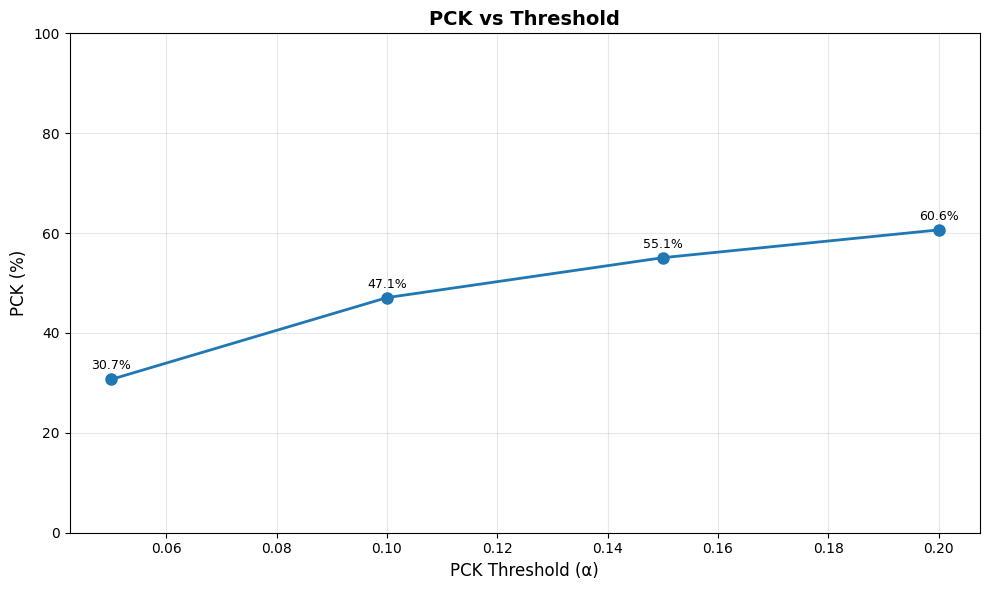

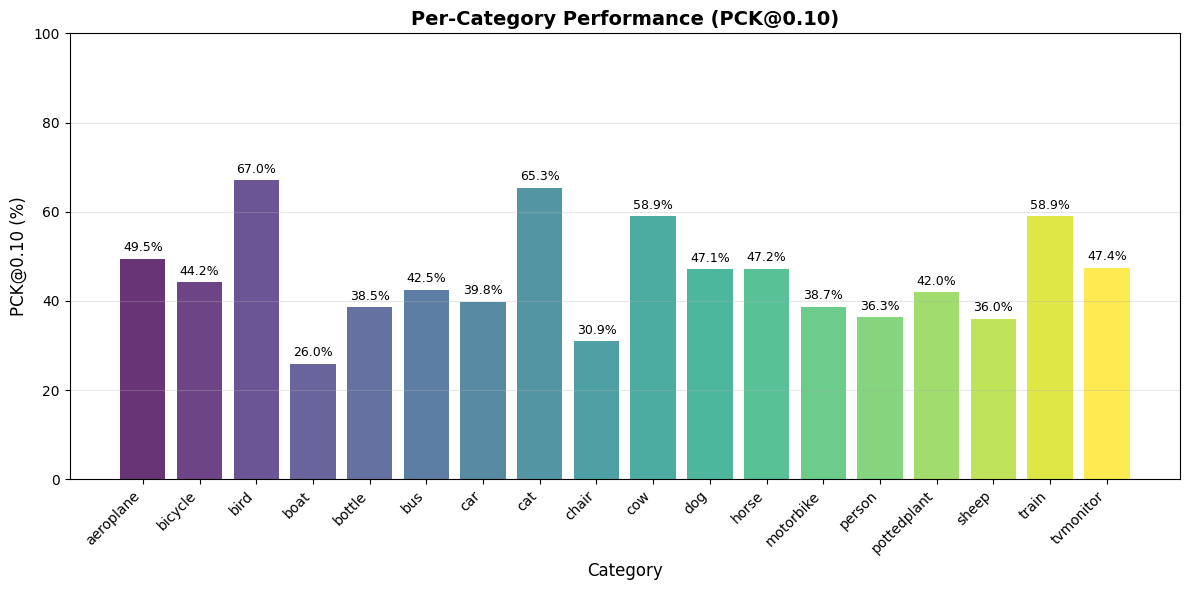

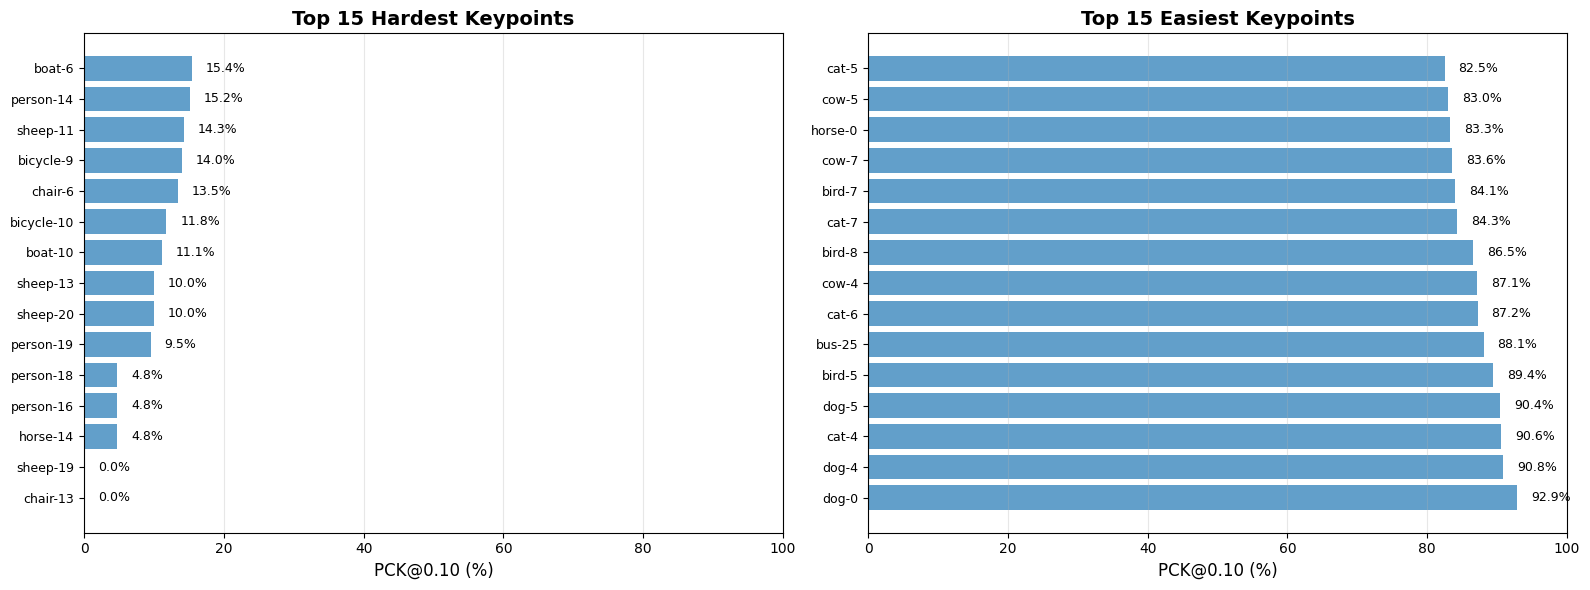

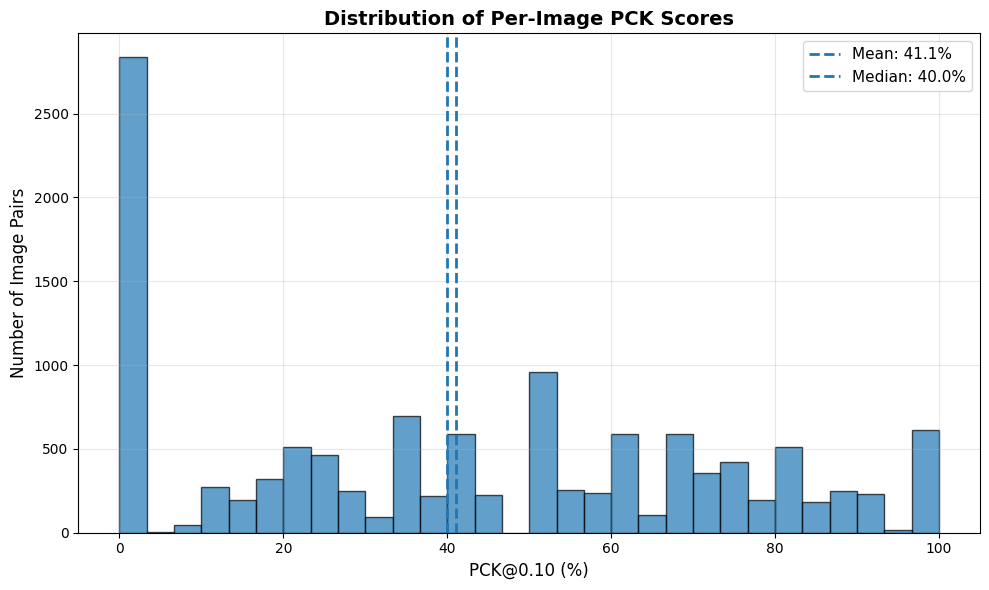

✅ Exported all metrics to ./results/sd15-baseline/
✅ Report generated in ./results/sd15-baseline/


In [11]:
analyzer = ResultsAnalyzer(metrics)
summary = analyzer.create_summary_table(threshold=0.10)
print("\nPCK@0.10 Summary:")
print(summary)

analyzer.generate_report(save_dir=f'./results/sd15-baseline')